In [79]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('legend', fontsize=10)

In [80]:
truth_train = np.loadtxt('../../data/truth_train.dat')
truth_test = np.loadtxt('../../data/truth_test.dat')
mask_w1_train = np.loadtxt('../../data/vvds_w1_train.mask').astype(bool)
mask_w1_test = np.loadtxt('../../data/vvds_w1_test.mask').astype(bool)
mask_w4_train = np.loadtxt('../../data/vvds_w4_train.mask').astype(bool)
mask_w4_test = np.loadtxt('../../data/vvds_w4_test.mask').astype(bool)
mag_i_train = np.loadtxt('../../data/mag_i.train.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')

In [81]:
tpc_test = np.loadtxt('../../data/w1_22_0_tpc_test.mlz', unpack=True, usecols=(2,))
som_test = np.loadtxt('../../data/w1_22_0_som_test.mlz', unpack=True, usecols=(2,))
hbc_all = np.loadtxt('../../data/w1_22_0_median.hbc', unpack=True, usecols=(0,))
hbc_cv = hbc_all[:-len(truth_test)]
hbc_test = hbc_all[-len(truth_test):]
bmc_test = np.loadtxt('../../data/w1_22_0.bmc')

In [82]:
# read in FLUX_RADIUS and MAG_i and make a classification
def morph_class(magnitude, half_radius, cut=[0, 25, 1.0, 3.0]):
    point_source = ((magnitude > cut[0]) & (magnitude < cut[1]) &
                    (half_radius > cut[2]) & (half_radius < cut[3]))
    return point_source.astype(np.int)

mag_i_lower = 17
mag_i_upper = 21.0
r_h_lower = 1.4
r_h_upper = 2.8

r_h_test = np.loadtxt('../../data/flux_radius.test.dat')
mag_i_test = np.loadtxt('../../data/mag_i.test.dat')
morph_test = morph_class(mag_i_test, r_h_test, cut=[mag_i_lower, mag_i_upper, r_h_lower, r_h_upper])

In [83]:
bins = np.arange(17, 25.5, 0.5)
bins_center = (bins[1:] + bins[:-1]) / 2

In [84]:
n_stars_w1_train, _ = np.histogram(mag_i_train[mask_w1_train & (truth_train == 1)], bins=bins)
n_stars_w1_test, _ = np.histogram(mag_i_test[mask_w1_test & (truth_test == 1)], bins=bins)
n_stars_w1 = n_stars_w1_train + n_stars_w1_test

#n_gals_w1_train, _ = np.histogram(mag_i_train[mask_w1_train & (truth_train == 0)], bins=bins)
#n_gals_w1_test, _ = np.histogram(mag_i_test[mask_w1_test & (truth_test == 0)], bins=bins)
#n_gals_w1 = n_gals_w1_train + n_gals_w1_test

n_total_w1_train, _ = np.histogram(mag_i_train[mask_w1_train], bins=bins)
n_total_w1_test, _ = np.histogram(mag_i_test[mask_w1_test], bins=bins)
n_total_w1 = n_total_w1_train + n_total_w1_test
            
n_stars_w4_train, _ = np.histogram(mag_i_train[mask_w4_train & (truth_train == 1)], bins=bins)
n_stars_w4_test, _ = np.histogram(mag_i_test[mask_w4_test & (truth_test == 1)], bins=bins)
n_stars_w4 = n_stars_w4_train + n_stars_w4_test

#n_gals_w4_train, _ = np.histogram(mag_i_train[mask_w4_train & (truth_train == 0)], bins=bins)
#n_gals_w4_test, _ = np.histogram(mag_i_test[mask_w4_test & (truth_test == 0)], bins=bins)
#n_gals_w4 = n_gals_w4_train + n_gals_w1_test

n_total_w4_train, _ = np.histogram(mag_i_train[mask_w4_train], bins=bins)
n_total_w4_test, _ = np.histogram(mag_i_test[mask_w4_test], bins=bins)
n_total_w4 = n_total_w4_train + n_total_w4_test

In [191]:
def calc_completeness_purity(truth, classif, mag, p_cut=0.5, bins=np.arange(16, 26, 0.5)):
    '''
    '''
    result = {}
    
    # true galaxies classified as stars
    gs_bin, _ = np.histogram(mag[(classif >= p_cut) & (truth == 0)], bins=bins)
    # true galaxies classified as galaxies
    gg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 0)], bins=bins)
    # true stars classified as galaxies
    sg_bin, _ = np.histogram(mag[(classif < p_cut) & (truth == 1)], bins=bins)
    # true stars classified as stars
    ss_bin, _ = np.histogram(mag[(classif >= p_cut) & (truth == 1)], bins=bins)

    # galaxy completeness
    mask = (gg_bin == 0) & (gs_bin == 0)
    g_comp_bin = np.zeros(len(gg_bin))
    g_comp_bin[mask] = np.nan
    g_comp_bin[~mask] = gg_bin[~mask] / (gg_bin[~mask] + gs_bin[~mask])
    
    g_comp_err_bin = np.zeros(len(gg_bin))
    g_comp_err_bin[mask] = np.nan
    g_comp_err_bin[~mask] = np.sqrt(gg_bin[~mask]) / (gg_bin[~mask] + gs_bin[~mask])
    
    # galaxy purity
    mask = (gg_bin == 0) & (sg_bin == 0)
    g_pur_bin = np.zeros(len(gg_bin))
    g_pur_bin[mask] = np.nan
    g_pur_bin[~mask] = gg_bin[~mask] / (gg_bin[~mask] + sg_bin[~mask])
    
    g_pur_err_bin = np.zeros(len(gg_bin))
    g_pur_err_bin[mask] = np.nan
    g_pur_err_bin[~mask] = np.sqrt(gg_bin[~mask]) / (gg_bin[~mask] + sg_bin[~mask])
    
    # star completeness
    mask = (ss_bin == 0) & (sg_bin == 0)
    s_comp_bin = np.zeros(len(ss_bin))
    s_comp_bin[mask] = np.nan
    s_comp_bin[~mask] = ss_bin[~mask] / (ss_bin[~mask] + sg_bin[~mask])
    
    s_comp_err_bin = np.zeros(len(ss_bin))
    s_comp_err_bin[mask] = np.nan
    s_comp_err_bin[~mask] = np.sqrt(ss_bin[~mask]) / (ss_bin[~mask] + sg_bin[~mask])

    # star purity
    mask = (ss_bin == 0) & (gs_bin == 0)
    s_pur_bin = np.zeros(len(ss_bin))
    s_pur_bin[mask] = np.nan
    s_pur_bin[~mask] = ss_bin[~mask] / (ss_bin[~mask] + gs_bin[~mask])

    s_pur_err_bin = np.zeros(len(ss_bin))
    s_pur_err_bin[mask] = np.nan
    s_pur_err_bin[~mask] = np.sqrt(ss_bin[~mask]) / (ss_bin[~mask] + gs_bin[~mask])

    result['galaxy_completeness'] = g_comp_bin
    result['galaxy_completeness_error'] = g_comp_err_bin
    result['galaxy_purity'] = g_pur_bin
    result['galaxy_purity_error'] = g_pur_err_bin
    result['star_completeness'] = s_comp_bin
    result['star_completeness_error'] = s_comp_err_bin
    result['star_purity'] = s_pur_bin
    result['star_purity_error'] = s_pur_err_bin

    return result

    
def find_purity_at(truth_test, clf, step=0.001, gc=None, gp=None, sc=None, sp=None):
    
    if bool(gc) and bool(sc) and bool(gp) and bool(sp):
        raise Exception('Specify only one of gp or sp parameter.')

    pbin = np.arange(0, 1, step)
    
    pure_all = np.zeros(len(pbin))
    comp_all = np.zeros(len(pbin))
    
    for i, p in enumerate(pbin):
        
        # true galaxies classified as stars
        gs = ((clf >= p) & (truth_test == 0)).sum()
        # true galaxies classified as galaxies
        gg = ((clf < p) & (truth_test == 0)).sum()
        # true stars classified as galaxies
        sg = ((clf < p) & (truth_test == 1)).sum()
        # true stars classified as stars
        ss = ((clf >= p) & (truth_test == 1)).sum()
    
        if gc is not None or gp is not None:
            if gg == 0 and sg == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = gg / (gg + sg)
            if gg == 0 and gs == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = gg / (gg + gs)
            
        if sc is not None or sp is not None:
            if ss == 0 and sg == 0:
                comp_all[i] = np.nan
            else:
                comp_all[i] = ss / (ss + sg)
            if ss == 0 and gs == 0:
                pure_all[i] = np.nan
            else:
                pure_all[i] = ss / (ss + gs)
    
    if gc is not None:
        ibin = np.argmin(np.abs(comp_all - gc))
        return pbin[ibin], pure_all[ibin]
    
    if gp is not None:
        ibin = np.argmin(np.abs(pure_all - gp))
        return pbin[ibin], comp_all[ibin]
    
    if sc is not None:
        ibin = np.argmin(np.abs(comp_all - sc))
        return pbin[ibin], pure_all[ibin]
    
    if sp is not None:
        ibin = np.argmin(np.abs(pure_all - sp))
        return pbin[ibin], comp_all[ibin]

In [192]:
morph = calc_completeness_purity(truth_test, morph_test, mag_i_test, p_cut=0.5, bins=bins)

In [ ]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, gc=0.9964, step=0.001)
bmc_mg = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=bins)
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.7145, step=0.001)
bmc_ms = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=bins)

In [225]:
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, gc=0.9964, step=0.001)
tpc_mg = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=bins)
tpc_p_cut, _ = find_purity_at(truth_test, tpc_test, sc=0.7145, step=0.001)
tpc_ms = calc_completeness_purity(truth_test, tpc_test, mag_i_test, p_cut=tpc_p_cut, bins=bins)

In [ ]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, gc=0.96, step=0.001)
bmc_dg = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=bins)
hbc_p_cut, _ = find_purity_at(truth_test, hbc_test, gc=0.96, step=0.001)
hbc_dg = calc_completeness_purity(truth_test, hbc_test, mag_i_test, p_cut=hbc_p_cut, bins=bins)

In [223]:
bmc_p_cut, _ = find_purity_at(truth_test, bmc_test, sc=0.25, step=0.00009)
bmc_ds = calc_completeness_purity(truth_test, bmc_test, mag_i_test, p_cut=bmc_p_cut, bins=bins)
hbc_p_cut, _ = find_purity_at(truth_test, hbc_test, sc=0.25, step=0.001)
hbc_ds = calc_completeness_purity(truth_test, hbc_test, mag_i_test, p_cut=hbc_p_cut, bins=bins)

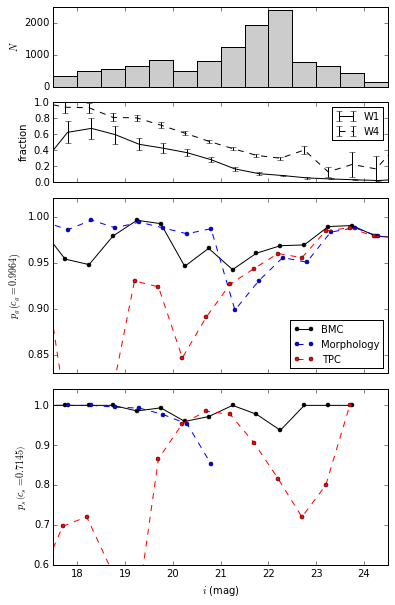

In [296]:
fig = plt.figure(figsize=(6, 10))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((6, 3), (1, 0), colspan=3)
ax2 = plt.subplot2grid((6, 3), (2, 0), colspan=3, rowspan=2)
ax3 = plt.subplot2grid((6, 3), (4, 0), colspan=3, rowspan=2)

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

x_offset = 0.05

ax0.hist(mag_i_test, bins=bins, histtype='bar', color='0.8')
ax0.set_xlim(17.5, 24.5)
ax0.set_yticks([0, 1000, 2000])
ax0.set_ylabel('$N$')

ax1.errorbar(bins_center + x_offset, n_stars_w1 / n_total_w1, yerr=np.sqrt(n_stars_w1) / n_total_w1,
             label='W1', ls='-', c='k')#, marker='o', markersize=4)
ax1.errorbar(bins_center, n_stars_w4 / n_total_w4, yerr=np.sqrt(n_stars_w4) / n_total_w4,
             label='W4', ls='--', c='k')#, marker='s', markersize=4)
#ax1.plot(bins_center, ngals / nvvds, label='galaxies', ls='--', c='k', marker='s')
ax1.set_xlim(17.5, 24.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel('fraction')
ax1.legend(loc='upper right')

ax2.errorbar(bins_center, bmc_mg['galaxy_purity'],
             #yerr=bmc_mg['galaxy_purity_error'],
             label='BMC', ls='-', c='k', marker='o', markersize=4)
ax2.errorbar(bins_center + x_offset, morph['galaxy_purity'],
             #yerr=morph['galaxy_purity_error'],
             label='Morphology', ls='--', c='b', marker='o', markersize=4)
ax2.errorbar(bins_center - x_offset, tpc_mg['galaxy_purity'],
             #yerr=morph['galaxy_purity_error'],
             label='TPC', ls='--', c='r', marker='o', markersize=4)
ax2.legend(loc='lower right')

ax2.set_xlim(17.5, 24.5)
ax2.set_ylim(0.83, 1.02)
#ax2.set_yticks([0.9, 0.95, 1.0])
ax2.set_ylabel(r'$p_g\left(c_g=0.9964\right)$')

ax3.errorbar(bins_center, bmc_ms['star_purity'],
             #yerr=[bmc_ms['star_purity_lower'], bmc_ms['star_purity_upper']],
             label='BMC', ls='-', c='k', marker='o', markersize=4)
ax3.errorbar(bins_center + x_offset, morph['star_purity'],
             #yerr=[morph['star_purity_lower'], morph['star_purity_upper']],
             label='Morphology', ls='--', c='b', marker='o', markersize=4)
ax3.errorbar(bins_center - x_offset, tpc_ms['star_purity'],
             #yerr=[tpc_ms['star_purity_lower'], tpc_ms['star_purity_upper']],
             label='TPC', ls='--', c='r', marker='o', markersize=4)

ax3.set_ylabel(r'$p_s\left(c_s=0.7145\right)$')
ax3.set_xlim(17.5, 24.5)
ax3.set_ylim(0.6, 1.04)

ax3.set_xlabel(r'$i$ (mag)')

plt.savefig('../../figures/purity_mag_cut.eps')

plt.show()